In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(url, names=columns, sep=',', skipinitialspace=True, na_values="?")
df = df.dropna()

# Encode categoricals
categorical = df.select_dtypes(include='object').columns
df[categorical] = df[categorical].apply(LabelEncoder().fit_transform)

X = df.drop("income", axis=1)
y = df["income"]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# For DP trees: scale to [0,1] and save bounds
X_minmax = MinMaxScaler().fit_transform(X)
x_train_mm, x_test_mm, _, _ = train_test_split(X_minmax, y, test_size=0.2, random_state=42)
bounds = (np.zeros(X.shape[1]), np.ones(X.shape[1]))


epsilons = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]

# Baseline models

In [11]:
# Logistic Regression
start = time.time()
baseline_lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
y_pred_lr = baseline_lr.predict(x_test)
baseline_acc_lr = accuracy_score(y_test, y_pred_lr)
baseline_f1_lr = f1_score(y_test, y_pred_lr)
runtime_baseline_lr = time.time() - start

In [12]:
print("Baseline Accuracy:", baseline_acc_lr)
print("Baseline F1 Score:", baseline_f1_lr)
print(f"Baseline Runtime: {runtime_baseline_lr:.2f} seconds")

Baseline Accuracy: 0.823139399966849
Baseline F1 Score: 0.5692369802180056
Baseline Runtime: 0.04 seconds


In [13]:
# Decision Tree
start = time.time()
baseline_dt = DecisionTreeClassifier().fit(x_train, y_train)
y_pred_dt = baseline_dt.predict(x_test)
baseline_acc_dt = accuracy_score(y_test, y_pred_dt)
baseline_f1_dt = f1_score(y_test, y_pred_dt)
runtime_baseline_dt = time.time() - start

In [14]:
print("Baseline Accuracy:", baseline_acc_dt)
print("Baseline F1 Score:", baseline_f1_dt)
print(f"Baseline Runtime: {runtime_baseline_dt:.2f} seconds")

Baseline Accuracy: 0.8098789988397149
Baseline F1 Score: 0.624795551193981
Baseline Runtime: 0.31 seconds


# Input Perturbation (Add noise to features)

In [15]:
def add_laplace_noise(data, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    return data + np.random.laplace(loc=0, scale=scale, size=data.shape)

acc_input_lr, f1_input_lr, runtime_input_lr = [], [], []
acc_input_dt, f1_input_dt, runtime_input_dt = [], [], []

for eps in epsilons:
    noisy = add_laplace_noise(x_train, eps)

    # LR
    start = time.time()
    lr = LogisticRegression(max_iter=1000).fit(noisy, y_train)
    y_pred = lr.predict(x_test)
    acc_input_lr.append(accuracy_score(y_test, y_pred))
    f1_input_lr.append(f1_score(y_test, y_pred))
    runtime_input_lr.append(time.time() - start)

    # DT
    start = time.time()
    dt = DecisionTreeClassifier().fit(noisy, y_train)
    y_pred = dt.predict(x_test)
    acc_input_dt.append(accuracy_score(y_test, y_pred))
    f1_input_dt.append(f1_score(y_test, y_pred))
    runtime_input_dt.append(time.time() - start)

#  Internal Perturbation (IBM DP Library)

In [ ]:
#import sys
#!{sys.executable} -m pip install diffprivlib


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from diffprivlib.models import LogisticRegression as DPLogReg
from diffprivlib.models import DecisionTreeClassifier as DPDecisionTree

acc_internal_lr, f1_internal_lr, runtime_internal_lr = [], [], []
acc_internal_dt, f1_internal_dt, runtime_internal_dt = [], [], []

for eps in epsilons:
    # DP Logistic Regression
    start = time.time()
    dp_lr = DPLogReg(epsilon=eps, data_norm=10.0).fit(x_train, y_train)
    y_pred = dp_lr.predict(x_test)
    acc_internal_lr.append(accuracy_score(y_test, y_pred))
    f1_internal_lr.append(f1_score(y_test, y_pred))
    runtime_internal_lr.append(time.time() - start)

    # DP Decision Tree
    start = time.time()
    dp_dt = DPDecisionTree(epsilon=eps, bounds=bounds).fit(x_train_mm, y_train)
    y_pred = dp_dt.predict(x_test_mm)
    acc_internal_dt.append(accuracy_score(y_test, y_pred))
    f1_internal_dt.append(f1_score(y_test, y_pred))
    runtime_internal_dt.append(time.time() - start)


c:\Users\tanbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffprivlib\models\forest.py:400: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "
c:\Users\tanbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffprivlib\models\forest.py:400: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "
c:\Users\tanbe\AppData\Local\Programs\Python\Python311\Lib\site-pack

# Output Perturbation (Add noise to model parameters)

In [18]:
def perturb_weights(model, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    model.coef_ += np.random.laplace(0, scale, model.coef_.shape)
    model.intercept_ += np.random.laplace(0, scale, model.intercept_.shape)
    return model

acc_output_lr, f1_output_lr, runtime_output_lr = [], [], []

for eps in epsilons:
    start = time.time()
    clf = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    clf = perturb_weights(clf, epsilon=eps)
    y_pred = clf.predict(x_test)
    acc_output_lr.append(accuracy_score(y_test, y_pred))
    f1_output_lr.append(f1_score(y_test, y_pred))
    runtime_output_lr.append(time.time() - start)

# Results

In [19]:

results = pd.DataFrame({
    "Epsilon": epsilons,
    "Input LR Acc": acc_input_lr,
    "Input LR F1": f1_input_lr,
    "Input DT Acc": acc_input_dt,
    "Input DT F1": f1_input_dt,
    "Internal LR Acc": acc_internal_lr,
    "Internal LR F1": f1_internal_lr,
    "Internal DT Acc": acc_internal_dt,
    "Internal DT F1": f1_internal_dt,
    "Output LR Acc": acc_output_lr,
    "Output LR F1": f1_output_lr
})

print(results.round(4))

   Epsilon  Input LR Acc  Input LR F1  Input DT Acc  Input DT F1  \
0     0.01        0.7464       0.0000        0.2536       0.4046   
1     0.10        0.7464       0.0000        0.6024       0.0408   
2     0.50        0.7467       0.0026        0.7243       0.3248   
3     1.00        0.7593       0.1081        0.7848       0.5297   
4     5.00        0.8175       0.5391        0.8124       0.6078   
5    10.00        0.8225       0.5627        0.8213       0.6331   

   Internal LR Acc  Internal LR F1  Internal DT Acc  Internal DT F1  \
0           0.6468          0.4461           0.7499          0.0321   
1           0.7820          0.5149           0.7462          0.0000   
2           0.8270          0.5925           0.7577          0.1053   
3           0.8202          0.5609           0.7560          0.1300   
4           0.8246          0.5754           0.7504          0.0321   
5           0.8231          0.5696           0.7529          0.0733   

   Output LR Acc  Output 

In [20]:
# Runtime Table
runtime = pd.DataFrame({
    "Epsilon": epsilons,
    "Runtime Input LR": runtime_input_lr,
    "Runtime Input DT": runtime_input_dt,
    "Runtime Internal LR": runtime_internal_lr,
    "Runtime Internal DT": runtime_internal_dt,
    "Runtime Output LR": runtime_output_lr
})
baseline_runtime_row = pd.DataFrame({
    "Epsilon": ["Baseline"],
    "Runtime Input LR": [runtime_baseline_lr],
    "Runtime Input DT": [runtime_baseline_dt],
    "Runtime Internal LR": [None],
    "Runtime Internal DT": [None],
    "Runtime Output LR": [None]
})
runtime_summary = pd.concat([baseline_runtime_row, runtime], ignore_index=True)
print(runtime_summary)

    Epsilon  Runtime Input LR  Runtime Input DT  Runtime Internal LR  \
0  Baseline          0.035958          0.310455                  NaN   
1      0.01          0.067579          1.360425             0.036799   
2       0.1          0.018081          0.902847             0.025706   
3       0.5          0.016156          0.643579             0.021329   
4       1.0          0.014034          0.654614             0.027339   
5       5.0          0.018995          0.681783             0.021197   
6      10.0          0.017581          0.721483             0.023201   

   Runtime Internal DT  Runtime Output LR  
0                  NaN                NaN  
1             0.052646           0.025854  
2             0.045411           0.018597  
3             0.046195           0.020426  
4             0.037343           0.017380  
5             0.047039           0.018005  
6             0.043600           0.019695  


C:\Users\tanbe\AppData\Local\Temp\ipykernel_10940\1977540734.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runtime_summary = pd.concat([baseline_runtime_row, runtime], ignore_index=True)


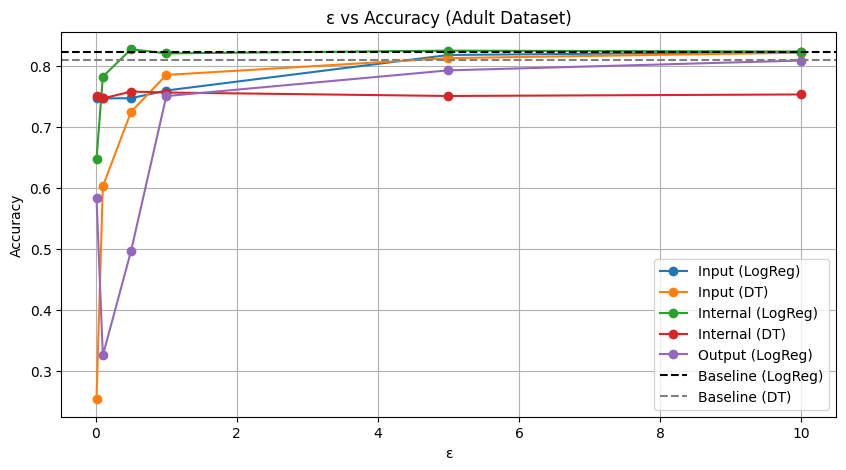

In [21]:
# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, acc_input_lr, marker='o', label='Input (LogReg)')
plt.plot(epsilons, acc_input_dt, marker='o', label='Input (DT)')
plt.plot(epsilons, acc_internal_lr, marker='o', label='Internal (LogReg)')
plt.plot(epsilons, acc_internal_dt, marker='o', label='Internal (DT)')
plt.plot(epsilons, acc_output_lr, marker='o', label='Output (LogReg)')
plt.axhline(baseline_acc_lr, color='black', linestyle='--', label='Baseline (LogReg)')
plt.axhline(baseline_acc_dt, color='gray', linestyle='--', label='Baseline (DT)')
plt.xlabel("ε")
plt.ylabel("Accuracy")
plt.title("ε vs Accuracy (Adult Dataset)")
plt.legend()
plt.grid(True)
plt.show()

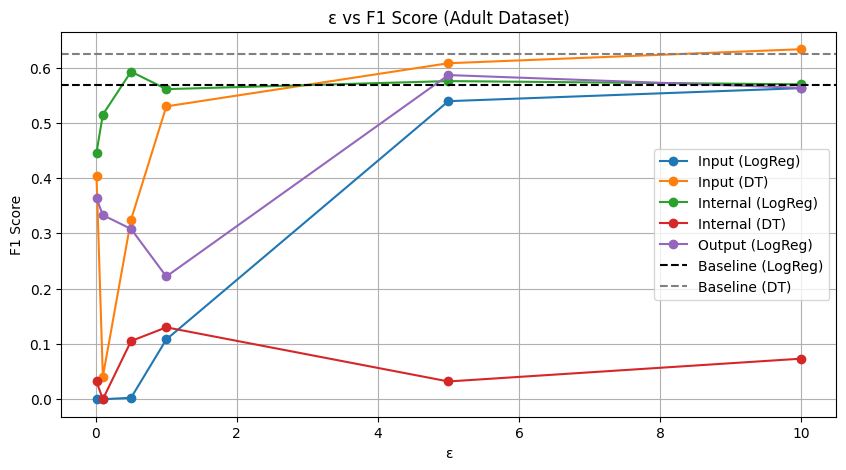

In [22]:
# F1 Score Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, f1_input_lr, marker='o', label='Input (LogReg)')
plt.plot(epsilons, f1_input_dt, marker='o', label='Input (DT)')
plt.plot(epsilons, f1_internal_lr, marker='o', label='Internal (LogReg)')
plt.plot(epsilons, f1_internal_dt, marker='o', label='Internal (DT)')
plt.plot(epsilons, f1_output_lr, marker='o', label='Output (LogReg)')
plt.axhline(baseline_f1_lr, color='black', linestyle='--', label='Baseline (LogReg)')
plt.axhline(baseline_f1_dt, color='gray', linestyle='--', label='Baseline (DT)')
plt.xlabel("ε")
plt.ylabel("F1 Score")
plt.title("ε vs F1 Score (Adult Dataset)")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Accuracy Drop
acc_drop_input_lr = [baseline_acc_lr - a for a in acc_input_lr]
acc_drop_input_dt = [baseline_acc_dt - a for a in acc_input_dt]
acc_drop_internal_lr = [baseline_acc_lr - a for a in acc_internal_lr]
acc_drop_internal_dt = [baseline_acc_dt - a for a in acc_internal_dt]
acc_drop_output_lr = [baseline_acc_lr - a for a in acc_output_lr]

# F1 Drop
f1_drop_input_lr = [baseline_f1_lr - f for f in f1_input_lr]
f1_drop_input_dt = [baseline_f1_dt - f for f in f1_input_dt]
f1_drop_internal_lr = [baseline_f1_lr - f for f in f1_internal_lr]
f1_drop_internal_dt = [baseline_f1_dt - f for f in f1_internal_dt]
f1_drop_output_lr = [baseline_f1_lr - f for f in f1_output_lr]

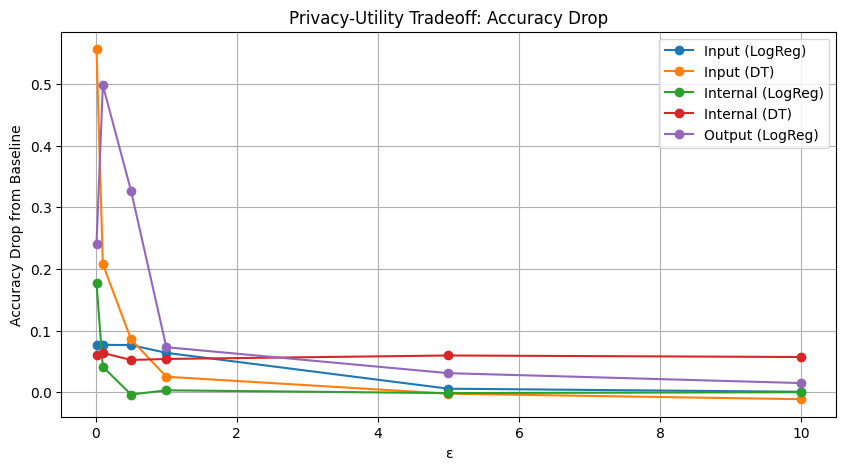

In [24]:
# Accuracy Drop Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, acc_drop_input_lr, marker='o', label='Input (LogReg)')
plt.plot(epsilons, acc_drop_input_dt, marker='o', label='Input (DT)')
plt.plot(epsilons, acc_drop_internal_lr, marker='o', label='Internal (LogReg)')
plt.plot(epsilons, acc_drop_internal_dt, marker='o', label='Internal (DT)')
plt.plot(epsilons, acc_drop_output_lr, marker='o', label='Output (LogReg)')
plt.xlabel("ε")
plt.ylabel("Accuracy Drop from Baseline")
plt.title("Privacy-Utility Tradeoff: Accuracy Drop")
plt.legend()
plt.grid(True)
plt.show()

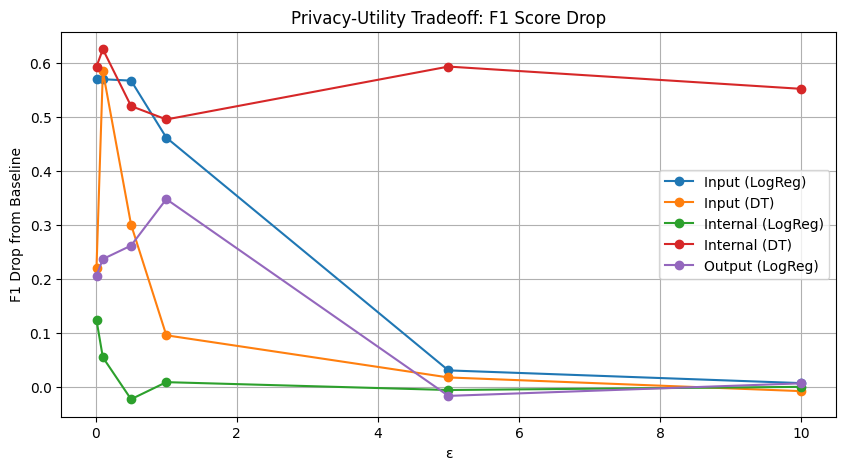

In [25]:
# F1 Drop Plot
plt.figure(figsize=(10, 5))
plt.plot(epsilons, f1_drop_input_lr, marker='o', label='Input (LogReg)')
plt.plot(epsilons, f1_drop_input_dt, marker='o', label='Input (DT)')
plt.plot(epsilons, f1_drop_internal_lr, marker='o', label='Internal (LogReg)')
plt.plot(epsilons, f1_drop_internal_dt, marker='o', label='Internal (DT)')
plt.plot(epsilons, f1_drop_output_lr, marker='o', label='Output (LogReg)')
plt.xlabel("ε")
plt.ylabel("F1 Drop from Baseline")
plt.title("Privacy-Utility Tradeoff: F1 Score Drop")
plt.legend()
plt.grid(True)
plt.show()